In [1]:
import sys
sys.path.append('C:\\Users\\sumaiyah\\Documents\\Univeristy\\diss\\misuse-AIaaS')

# Import filepaths
from notebooks import FIC_10minute_filepath

In [2]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer

from timeit import default_timer as timer
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

In [3]:
fic_df = pd.read_pickle(FIC_10minute_filepath(1)).drop(columns=[0,1,2,3])

In [4]:
fic_df['n_calls'] = (fic_df != 0).astype(int).sum(axis=1)

heavy_users_df = fic_df.sort_values(by='n_calls', ascending=False).head(10000).sample(frac=1).head(200)
heavy_users_df['class'] = 1

normal_users_df = fic_df[fic_df['n_calls'] > 1].sort_values(by='n_calls', ascending=True).head(20000).sample(frac=1).head(9800)
normal_users_df['class'] = 0

all_users_df = pd.concat([normal_users_df, heavy_users_df]).sample(frac=1).reset_index(drop=True)
y = all_users_df['class']

In [5]:
# Preprocess data
all_users_df_norm = TimeSeriesScalerMeanVariance().fit_transform(all_users_df.drop(columns=['class', 'n_calls']))

# Need values in specific shape for tslearn clustering
all_users_df_vals = to_time_series_dataset(all_users_df_norm)
print(all_users_df_vals.shape)

(10000, 144, 1)


## DBScan Clustering

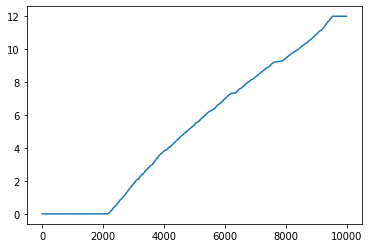

In [6]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

# ideal value for ε will be equal to the distance value at the point of maximum curvature
# ended up looping through combinations of MinPts and ε values slightly above and below the values estimated here to find the model of best fit

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(all_users_df_vals[:,:,0])
distances, indices = neighbors_fit.kneighbors(all_users_df_vals[:,:,0])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [7]:
from sklearn.cluster import DBSCAN

start = timer()

db = DBSCAN(eps=12, min_samples=5).fit(all_users_df_vals[:,:,0])
labels = pd.Series(db.labels_)

end = timer()
print('Clustering took %f seconds' % ((end - start)))

print(labels.value_counts())
print(list(labels.value_counts().values))

Clustering took 2.008281 seconds
 0    9706
-1     294
dtype: int64
[9706, 294]


## KMeans

In [8]:
k=2
print('Results of K-means Clustering with k=%d' % k)
    
start = timer()

km = TimeSeriesKMeans(n_clusters=k, verbose=False, random_state=42, n_jobs=-1)
kmeans_predictions = km.fit_predict(all_users_df_vals)

end = timer()
print('Clustering k=%d took %f seconds' % (k, (end - start)))

km_clusters = pd.Series(kmeans_predictions)
print(km_clusters.value_counts())
print(km_clusters.value_counts().values.tolist(), '\n')

Results of K-means Clustering with k=2
Clustering k=2 took 8.252040 seconds
0    9296
1     704
dtype: int64
[9296, 704] 



## DTW Kmeans

In [9]:
k=2
print('Results of K-means Clustering with k=%d' % k)
    
start = timer()

dtw_km = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=True, random_state=42, n_jobs=-1)
dtw_kmeans_predictions = dtw_km.fit_predict(all_users_df_vals)

end = timer()
print('Clustering k=%d took %f seconds' % (k, (end - start)))

km_clusters = pd.Series(dtw_kmeans_predictions)
print(km_clusters.value_counts())
print(km_clusters.value_counts().values.tolist(), '\n')

Results of K-means Clustering with k=2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 10000 out of 

80.135 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

51.051 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

49.756 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.990 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.594 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.311 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.264 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.232 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.214 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.208 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.204 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.202 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.201 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.200 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.200 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.200 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.199 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.199 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.199 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.199 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.192 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.191 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.191 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.191 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

48.191 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

Clustering k=2 took 2319.165866 seconds
1    5665
0    4335
dtype: int64
[5665, 4335] 



[Parallel(n_jobs=-1)]: Done 19992 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 20000 out of 20000 | elapsed:    4.4s finished


In [10]:
# Binarise the classes so it is largest class vs all other classes
# Largest class = 0, smaller class = 1
dbscan_predictions = pd.Series(labels)
a = np.array(dbscan_predictions.values.tolist())
dbscan_predictions = np.where(a != 0, 1, a).tolist()

dbscan_predictions = pd.Series(dbscan_predictions)
kmeans_predictions = pd.Series(kmeans_predictions)
dtw_kmeans_predictions = pd.Series(dtw_kmeans_predictions)

In [11]:
# kmeans_predictions = np.array(kmeans_predictions)
# kmeans_predictions = np.where(a==0, 2, a)
# kmeans_predictions = np.where(a==1, 0, a)
# kmeans_predictions = np.where(a==2, 1, a)

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_results(y, y_pred, text):
    print(text)
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y, y_pred)
    print('F1 score: %f' % f1)
    
    print('\n')
    
print_results(y, dbscan_predictions, 'DBScan: '),
print_results(y, kmeans_predictions, 'Kmeans: ')
print_results(y, dtw_kmeans_predictions, 'DTW K-means: ')
len(y)

DBScan: 
Accuracy: 0.958200
Precision: 0.129252
Recall: 0.190000
F1 score: 0.153846


Kmeans: 
Accuracy: 0.909600
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


DTW K-means: 
Accuracy: 0.420500
Precision: 0.006178
Recall: 0.175000
F1 score: 0.011935




10000

In [14]:
data_df = pd.DataFrame(all_users_df_vals[:, :, 0])
data_df['dbscan'] = dbscan_predictions
average_dbscan_cluster = data_df.groupby('dbscan').mean()

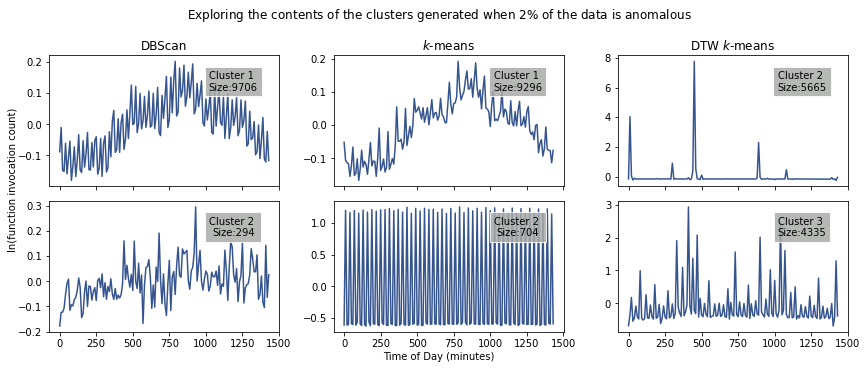

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True, tight_layout = True)
colours = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:gray', 'tab:brown']

# Row and column labels for subplot
cols = ['DBScan', '$k$-means', 'DTW $k$-means']
for ax, col in zip((axes[0,0], axes[0,1], axes[0,2]), cols):
    ax.set_title(col)

# x
x = list(range(0 ,1440, 10))
    
# Set common labels
fig.text(0.5, 0, 'Time of Day (minutes)', ha='center')
fig.text(0, 0.5, 'ln(function invocation count)', va='center', rotation='vertical')
fig.suptitle('Exploring the contents of the clusters generated when $2\%$ of the data is anomalous')

# DBScan
cluster_order = pd.Series(dbscan_predictions).value_counts().keys().tolist()
for yi in range(len(cluster_order)):
    cluster_index = cluster_order[yi]
    axes[yi,0].plot(x, average_dbscan_cluster.values[cluster_index], color='#36558F')   
    
    # Plot text in same position in each subplot
    text = 'Cluster %d \nSize:%d' % ((yi + 1), pd.Series(labels).value_counts().values[yi])
    t= axes[yi,0].text(0.8, 0.8, text,
             horizontalalignment='center',
             verticalalignment='center',
             transform = axes[yi,0].transAxes,
             color="black")
    t.set_bbox(dict(facecolor='#A9ACA9', alpha=0.85, edgecolor='white'))

# Kmeans
cluster_order = pd.Series(kmeans_predictions).value_counts().keys().tolist()
for yi in range(len(cluster_order)):
    cluster_index = cluster_order[yi]
    axes[yi,1].plot(x, km.cluster_centers_[cluster_index].ravel()[:int(7 * (1440 / 10))], color='#36558F')
    
    # Plot text in same position in each subplot
    text = 'Cluster %d \nSize:%d' % ((yi + 1), pd.Series(kmeans_predictions).value_counts().values[yi])
    t= axes[yi,1].text(0.8, 0.8, text,
             horizontalalignment='center',
             verticalalignment='center',
             transform = axes[yi,1].transAxes,
             color='black')
    t.set_bbox(dict(facecolor='#A9ACA9', alpha=0.85, edgecolor='white'))

# Dynamic Time warped k-means
cluster_order = pd.Series(dtw_kmeans_predictions).value_counts().keys().tolist()
for yi in range(len(cluster_order)):
    cluster_index = cluster_order[yi]
    axes[yi,2].plot(x, dtw_km.cluster_centers_[cluster_index].ravel()[:int(7 * (1440 / 10))], color='#36558F')
    
    # Plot text in same position in each subplot
    text = 'Cluster %d \nSize:%d' % ((yi + 2), pd.Series(dtw_kmeans_predictions).value_counts().values[yi])
    t= axes[yi,2].text(0.8, 0.8, text,
             horizontalalignment='center',
             verticalalignment='center',
             transform = axes[yi,2].transAxes,
             color='black')
    t.set_bbox(dict(facecolor='#A9ACA9', alpha=0.85, edgecolor='white'))

# axes[0,0].set_xticks(range(24))

fig.tight_layout()
fig.savefig('figs/final/test3f.png', dpi=250)
plt.show()

| Clustering Algorithm | Clusters     | Time (s)    |
|----------------------|--------------|-------------|
| DBScan               | [9724, 276]  | 5.7    |
| $k$-means            | [9296, 704]  | 22.3   |
| DTW $k$-means        | [5665, 4335] | 2319.2|

In [ ]:
# DBScan: 
# Accuracy: 0.958200
# Precision: 0.129252
# Recall: 0.190000
# F1 score: 0.153846


# Kmeans: 
# Accuracy: 0.909600
# Precision: 0.000000
# Recall: 0.000000
# F1 score: 0.000000


# DTW K-means: 
# Accuracy: 0.420500
# Precision: 0.006178
# Recall: 0.175000
# F1 score: 0.011935